In [1]:
import pandas as pd


In [12]:
import pandas as pd

In [2]:
df_sample = pd.read_csv('/content/test_samples.csv')

In [4]:
from openai import OpenAI


In [5]:
def get_tool_schema():
    return [
        {
            "type": "function",
            "function": {
                "name": "classify_substance",
                "description": "Classifies a given comment.",
                "parameters": {
                    "type": "object",
                    "properties": {
                        "cluster": {
                            "type": "string",
                            "description": "The cluster label(s) for the comment."
                        }
                    },
                    "required": ["cluster"]
                }
            }
        }
    ]


In [10]:
sys_message = """

You are an AI toxicity classification engine. Your task is to read a user's input and assign it exactly one label from a predefined set of categories. Follow these instructions carefully:

1. Classification Categories:
   - toxic: General hostile, vulgar, or hateful language that is offensive but not highly destructive (e.g. insults, casual profanity).
   - severe_toxic: Extremely abusive or hateful language that explicitly encourages violence or extreme demeaning of a protected group.
   - obscene: Language or content that is sexually explicit, graphic, or pornographic in nature.
   - threat: Direct or veiled statements of intent to inflict harm or violence on a target.
   - insult: Derogatory remarks aimed at humiliating or belittling the target without necessarily calling for violence.
   - identity_hate: Hostile or demeaning language specifically targeting a protected characteristic (e.g. race, religion, gender, sexual orientation).

2. Classification Instructions:
   - Select exactly one label from ["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"].
   - If the content could fall under more than one category, choose the single most specific or severe label.
   - If the input contains no toxicity or hateful content, classify it as "none".

3. User Input:
<user_input>
{{USER_INPUT}}
</user_input>

4. Output Instructions:
   - Provide your classification as a single word, with no additional text or punctuation.
   - Your response must be one of the following: "toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate", or "none".

Classify the user input now:
<classification>

"""

In [7]:
import asyncio
import pandas as pd
import json
import aiofiles
from openai import AsyncOpenAI

async_client = AsyncOpenAI()


async def get_cluster_from_llm(substance, system_message, model="gemini-2.5-pro-preview-03-25"):
    if pd.isna(substance) or not str(substance).strip():
        return "NA"

    user_message = f"which Cluster it goes to: {substance}"

    try:
        response = await async_client.chat.completions.create(
            model=model,
            messages=[
                {"role": "system", "content": system_message},
                {"role": "user", "content": user_message}
            ],
            tools=get_tool_schema(),
            tool_choice="auto",
            temperature = 0.4
        )

        tool_calls = response.choices[0].message.tool_calls
        if tool_calls and len(tool_calls) > 0:
            tool_response = tool_calls[0].function.arguments
            return json.loads(tool_response)["cluster"]

        assistant_response = response.choices[0].message.content
        if assistant_response:
            try:
                return json.loads(assistant_response).get("cluster", "NA")
            except json.JSONDecodeError:
                return assistant_response.strip()
        else:
            return "NA"

    except Exception as e:
        return "NA"


async def process_dataframe(df, system_message, output_file):
    tasks = []
    for idx, row in df.iterrows():
        tasks.append(get_cluster_from_llm(row["comment_text"], system_message))

    results = await asyncio.gather(*tasks)
    df["cluster"] = results

    async with aiofiles.open(output_file, mode='w') as f:
        await f.write(df.to_csv(index=False))





In [8]:
import nest_asyncio
import asyncio
nest_asyncio.apply()

In [11]:
# Usage
system_message = sys_message
df_sample = pd.read_csv("test_samples.csv")
output_file = "gemini_test_results.csv"

await process_dataframe(df_sample, system_message, output_file)

In [ ]:
# output_file = "gemini_test_results.csv"
# df_sample.to_csv(output_file, index=False)

In [16]:
import pandas as pd

samples = pd.read_csv("test_samples.csv")
labels  = pd.read_csv("test_labels.csv")

merged = samples.merge(labels, on="id", how="left")

print(merged.head())
merged.to_csv("test_samples_with_labels.csv", index=False)

                 id                                       comment_text  toxic  \
0  d4ede52e6fc315a2  == Sky city == \n\n Hello, \n\n I noticed that...      0   
1  345bb5c81a8a6797  " \n\n ""Specifically, Allied forces suffered ...      0   
2  73ef403fa5a095e6  " \n You know what, I think you're just insecu...     -1   
3  d5290e73cf136173  " \n\n == LOL == \n\n LOLLOLOLOLOOLOLLOLOLOLLO...     -1   
4  d4911d1fd9989582  he is not a bad guy he is a sexy guy and his b...     -1   

   severe_toxic  obscene  threat  insult  identity_hate  
0             0        0       0       0              0  
1             0        0       0       0              0  
2            -1       -1      -1      -1             -1  
3            -1       -1      -1      -1             -1  
4            -1       -1      -1      -1             -1  


rename cluster column to toxicity

In [18]:

pred = pd.read_csv("gemini_test_results.csv")
truth = pd.read_csv("test_samples_with_labels.csv")

LABELS = ["toxic","severe_toxic","obscene","threat","insult","identity_hate"]

def get_cluster(row):
    labs = [lab for lab in LABELS if (lab in row and row[lab] != -1 and row[lab] == 1)]
    return ",".join(labs) if labs else "none"

truth["cluster"] = truth.apply(get_cluster, axis=1)

row_has_valid_label = truth[LABELS].apply(lambda row: any([x != -1 for x in row]), axis=1)
truth_eval = truth[row_has_valid_label]

df = pred.merge(truth_eval[["id", "cluster"]], on="id", how="inner")

def is_correct(row):
    gt = str(row["cluster"]).strip().lower()
    pred = str(row["toxicity"]).strip().lower() if pd.notnull(row["toxicity"]) else "none"
    gt_set = set([g.strip() for g in gt.split(",")]) if gt and gt != "none" else set()
    if (not gt_set and (not pred or pred == "none")) or (pred in gt_set):
        return 1
    else:
        return 0


df["is_correct"] = df.apply(is_correct, axis=1)
accuracy = df["is_correct"].mean()

print(f"Loose cluster label accuracy (ignoring -1s): {accuracy:.4f}")

Loose cluster label accuracy (ignoring -1s): 0.7475



Binary confusion matrix ('none'=0, 'any toxic'=1):
            Pred none  Pred toxic
True none         284          78
True toxic          7          31


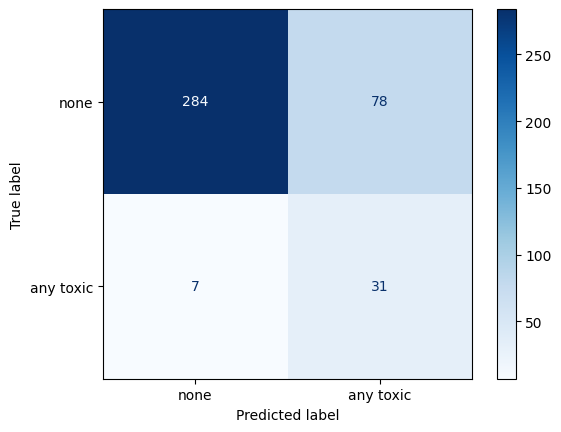

In [19]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt


def cluster_to_binary(cluster):
    return 0 if cluster == "none" else 1

def pred_to_binary(pred):
    return 0 if (pred is None or str(pred).strip().lower() in ["none", "nan", ""]) else 1

y_true_bin = df["cluster"].apply(cluster_to_binary)
y_pred_bin = df["toxicity"].apply(pred_to_binary)

cm = confusion_matrix(y_true_bin, y_pred_bin)
print("\nBinary confusion matrix ('none'=0, 'any toxic'=1):")
print(pd.DataFrame(cm, index=["True none", "True toxic"], columns=["Pred none", "Pred toxic"]))

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["none", "any toxic"])
disp.plot(cmap="Blues")
plt.show()